# Task 1 
- solo utilizando Sockshop: 1.1, 2.1, 3.1, 4.1



In [1]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from baro.anomaly_detection import bocpd
from baro.root_cause_analysis import robust_scorer
from baro.utility import drop_constant
from sklearn import datasets
from pandas import read_csv
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from baro.anomaly_detection import bocpd, nsigma
from baro.root_cause_analysis import robust_scorer
from baro.utility import drop_constant
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder, StandardScaler


# 1. Cargar los datos
# Cargar los datos de los archivos CSV
carts_cpu = pd.read_csv('carts_cpu/1/new_data.csv')
carts_delays = pd.read_csv('carts_delay/1/new_data.csv')
carts_loss = pd.read_csv('carts_loss/1/new_data.csv')
carts_mem = pd.read_csv('carts_mem/1/new_data.csv')

# Añadir una nueva columna con el nombre del archivo de origen
carts_cpu['file_origin'] = 'carts_cpu'
carts_delays['file_origin'] = 'carts_delay'
carts_loss['file_origin'] = 'carts_loss'
carts_mem['file_origin'] = 'carts_mem'


# Combinar todos los DataFrames en uno solo
df = pd.concat([carts_cpu, carts_delays, carts_loss, carts_mem], ignore_index=True)
print("Número de filas en el DataFrame original:", df.shape[0])
print(df[['Abnormality Class', 'file_origin']].value_counts())





Número de filas en el DataFrame original: 2884
Abnormality Class  file_origin
Abnormal           carts_cpu      361
                   carts_delay    361
                   carts_loss     361
                   carts_mem      361
Normal             carts_cpu      360
                   carts_delay    360
                   carts_loss     360
                   carts_mem      360
Name: count, dtype: int64


In [2]:

# Asignar la clase de anomalía dependiendo del archivo de origen
def assign_anomaly_class(row):
    if row['Abnormality Class'] == 'Abnormal':
        if row['file_origin'] == 'carts_cpu':
            return 'CPU HOG'
        elif row['file_origin'] == 'carts_mem':
            return 'MEM LEAK'
        elif row['file_origin'] == 'carts_loss':
            return 'Packet Loss'
        elif row['file_origin'] == 'carts_delay':
            return 'Packet Delay'
    return row['Abnormality Class']

df['Abnormality Class'] = df.apply(assign_anomaly_class, axis=1)


# Verificar los cambios
print(df[['Abnormality Class']].value_counts())

# Eliminar la columna 'file_origin'
if 'file_origin' in df.columns:
    df.drop(['file_origin'], axis=1, inplace=True)
#print(df.columns)


Abnormality Class
Normal               1440
CPU HOG               361
MEM LEAK              361
Packet Delay          361
Packet Loss           361
Name: count, dtype: int64


In [3]:

df.head(5)


,time,carts_container-cpu-system-seconds-total,carts-db_container-cpu-system-seconds-total,catalogue_container-cpu-system-seconds-total,catalogue-db_container-cpu-system-seconds-total,front-end_container-cpu-system-seconds-total,orders_container-cpu-system-seconds-total,orders-db_container-cpu-system-seconds-total,payment_container-cpu-system-seconds-total,queue-master_container-cpu-system-seconds-total,...,192-168-27-60-9100_node-network-receive-drop-total,192-168-33-0-9100_node-network-receive-drop-total,192-168-37-154-9100_node-network-receive-drop-total,192-168-76-116-9100_node-network-receive-drop-total,192-168-15-8-9100_node-network-transmit-drop-total,192-168-27-60-9100_node-network-transmit-drop-total,192-168-33-0-9100_node-network-transmit-drop-total,192-168-37-154-9100_node-network-transmit-drop-total,192-168-76-116-9100_node-network-transmit-drop-total,Abnormality Class
0,1693068309,0.961682,0.334536,0.230996,0.045831,1.732266,0.962811,0.065308,0.022688,0.066647,...,0,0,0,0,0,0,0,0,0,Normal
1,1693068310,0.961682,0.334536,0.230996,0.045831,1.732266,0.962811,0.065308,0.022688,0.066647,...,0,0,0,0,0,0,0,0,0,Normal
2,1693068311,0.961682,0.334536,0.252195,0.045831,1.732266,0.817558,0.065308,0.022688,0.066647,...,0,0,0,0,0,0,0,0,0,Normal
3,1693068312,0.961682,0.334536,0.252195,0.045831,1.732266,0.801511,0.065308,0.022688,0.066647,...,0,0,0,0,0,0,0,0,0,Normal
4,1693068313,0.961682,0.334536,0.252195,0.045831,1.732266,0.785464,0.062441,0.022688,0.066647,...,0,0,0,0,0,0,0,0,0,Normal


In [4]:
df.describe()


,time,carts_container-cpu-system-seconds-total,carts-db_container-cpu-system-seconds-total,catalogue_container-cpu-system-seconds-total,catalogue-db_container-cpu-system-seconds-total,front-end_container-cpu-system-seconds-total,orders_container-cpu-system-seconds-total,orders-db_container-cpu-system-seconds-total,payment_container-cpu-system-seconds-total,queue-master_container-cpu-system-seconds-total,...,192-168-15-8-9100_node-network-receive-drop-total,192-168-27-60-9100_node-network-receive-drop-total,192-168-33-0-9100_node-network-receive-drop-total,192-168-37-154-9100_node-network-receive-drop-total,192-168-76-116-9100_node-network-receive-drop-total,192-168-15-8-9100_node-network-transmit-drop-total,192-168-27-60-9100_node-network-transmit-drop-total,192-168-33-0-9100_node-network-transmit-drop-total,192-168-37-154-9100_node-network-transmit-drop-total,192-168-76-116-9100_node-network-transmit-drop-total
count,2.884000e+03,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,...,2884.0,2884.0,2884.0,2884.0,2884.0,2884.0,2884.0,2884.0,2884.0,2884.0
mean,1.693070e+09,3.028393,0.335897,0.220799,0.063645,1.597385,0.492247,0.049724,0.078853,0.097409,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,1.053846e+03,6.941536,0.081308,0.048915,0.025629,0.180728,0.121250,0.021277,0.033739,0.036600,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,1.693068e+09,0.175000,0.125000,0.056820,0.000000,0.850000,0.222222,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,1.693069e+09,0.418788,0.279780,0.190232,0.044919,1.477427,0.405811,0.037225,0.051221,0.071830,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,1.693070e+09,0.530223,0.328037,0.220751,0.063549,1.618741,0.475285,0.047566,0.079564,0.091588,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,1.693071e+09,0.679824,0.384344,0.253279,0.083365,1.727026,0.555532,0.064052,0.098593,0.120884,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.693072e+09,23.831259,0.714439,0.365048,0.139338,2.038708,0.962811,0.134763,0.170558,0.219277,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:

# DataFrame with Abnormality Class == 'Normal'
df_normal = df[df['Abnormality Class'] == 'Normal']

# DataFrame with the rest of the Abnormality Classes
df_abnormal = df[df['Abnormality Class'] != 'Normal']

# Display the shapes of the new DataFrames
print("Shape of df_normal:", df_normal.shape)
print("Shape of df_abnormal:", df_abnormal.shape)
null_count1 = df_normal.isnull().sum().sum()
print('Number of null values in df_normal:', null_count1)
null_count2 = df_abnormal.isnull().sum().sum()
print('Number of null values in df_abnormal:', null_count2)



Shape of df_normal: (1440, 439)
Shape of df_abnormal: (1444, 439)
Number of null values in df_normal: 80
Number of null values in df_abnormal: 296


In [11]:
# Create a mapping for the abnormal classes
abnormal_mapping = {
    'CPU HOG': 2.0,
    'MEM LEAK': 3.0,
    'Packet Loss': 4.0,
    'Packet Delay': 5.0
}

# Apply the mapping to the 'Abnormality Class' column
df['Abnormality Class'] = df['Abnormality Class'].replace(abnormal_mapping)
df['Abnormality Class'] = df['Abnormality Class'].replace('Normal', 1)

# Verify the changes
print(df['Abnormality Class'].value_counts())
df.to_csv('abnormality_class.csv', index=False)

Abnormality Class
1.0    1440
2.0     361
5.0     361
4.0     361
3.0     361
Name: count, dtype: int64


In [7]:
df.count()

time                                                    2884
carts_container-cpu-system-seconds-total                2884
carts-db_container-cpu-system-seconds-total             2884
catalogue_container-cpu-system-seconds-total            2884
catalogue-db_container-cpu-system-seconds-total         2884
                                                        ... 
192-168-27-60-9100_node-network-transmit-drop-total     2884
192-168-33-0-9100_node-network-transmit-drop-total      2884
192-168-37-154-9100_node-network-transmit-drop-total    2884
192-168-76-116-9100_node-network-transmit-drop-total    2884
Abnormality Class                                       2884
Length: 439, dtype: int64

LR: 0.9978317334839074 (0.0021682763190693606)
LDA: nan (nan)
KNN: 0.9939281008846228 (0.005200477267402195)
CART: 0.9978336156597025 (0.002905392425590591)
NB: 0.9835271974402409 (0.010220806587037239)
SVM: 0.994797666102014 (0.005414782604810755)


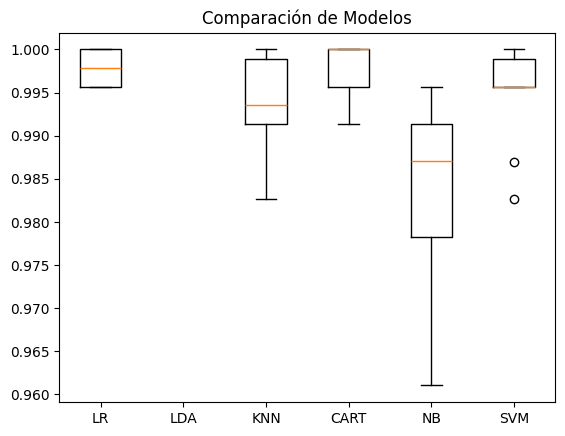

Exactitud: 0.9982668977469671
Matriz de Confusión:
 [[283   0   0   1   0]
 [  0  80   0   0   0]
 [  0   0  76   0   0]
 [  0   0   0  64   0]
 [  0   0   0   0  73]]
Reporte de Clasificación:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       284
           2       1.00      1.00      1.00        80
           3       1.00      1.00      1.00        76
           4       0.98      1.00      0.99        64
           5       1.00      1.00      1.00        73

    accuracy                           1.00       577
   macro avg       1.00      1.00      1.00       577
weighted avg       1.00      1.00      1.00       577



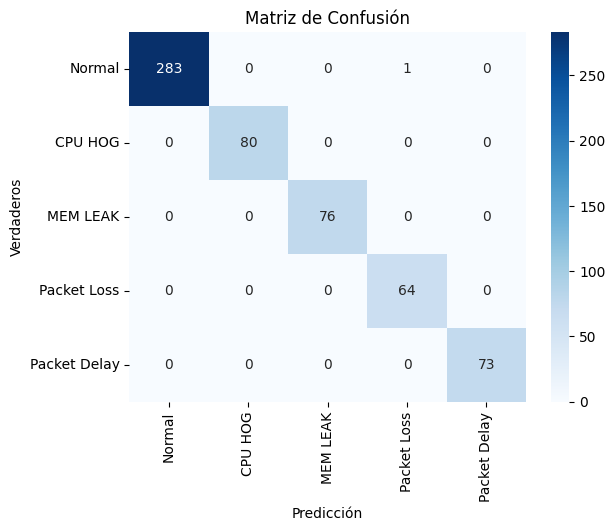

In [8]:
# Import necessary libraries
from sklearn.impute import KNNImputer
import seaborn as sns

# 3. Imputación de valores nulos (si es necesario)
# Create an instance of KNNImputer with 3 neighbors to fill missing values
imputer = KNNImputer(n_neighbors=3)
# Apply the imputer to the DataFrame and create a new DataFrame with imputed values
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# 4. Asignar las características (X) y la etiqueta (y)
# Separate features (X) and target label (y) from the imputed DataFrame
X = df_imputed.drop('Abnormality Class', axis=1)
y = df_imputed['Abnormality Class']

# 5. Dividir los datos en conjunto de entrenamiento y validación (80% - 20%)
# Split the data into training and validation sets (80% training, 20% validation)
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.20, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)


# Round and convert the target labels to integers
y_train = y_train.round().astype(int)
y_validation = y_validation.round().astype(int)

# 6. Definir los modelos a evaluar
# Define a list of models to evaluate
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))  # Logistic Regression
models.append(('LDA', LinearDiscriminantAnalysis()))  # Linear Discriminant Analysis
models.append(('KNN', KNeighborsClassifier()))  # K-Nearest Neighbors Classifier
models.append(('CART', DecisionTreeClassifier()))  # Decision Tree Classifier
models.append(('NB', GaussianNB()))  # Gaussian Naive Bayes
models.append(('SVM', SVC()))  # Support Vector Machines

# 7. Evaluación de los modelos usando validación cruzada
# Evaluate the models using cross-validation
results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print(f'{name}: {cv_results.mean()} ({cv_results.std()})')

# 8. Comparar los modelos
# Compare the models using a box plot
plt.boxplot(results, labels=names)
plt.title('Comparación de Modelos')
plt.show()


# 9. Entrenar el modelo seleccionado (Regresión Logística en este caso)
# Train the selected model (Logistic Regression in this case)
model = KNeighborsClassifier(n_neighbors=3)
#model = LogisticRegression(solver='liblinear', multi_class='ovr')
model.fit(X_train, y_train)


# 10. Hacer predicciones con el conjunto de validación
# Make predictions on the validation set
predictions = model.predict(X_validation)
predictions = predictions.round().astype(int)


# 11. Evaluar las predicciones
# Evaluate the predictions
print("Exactitud:", accuracy_score(y_validation, predictions))
print("Matriz de Confusión:\n", confusion_matrix(y_validation, predictions))
print("Reporte de Clasificación:\n", classification_report(y_validation, predictions))


# 12. Visualizar la matriz de confusión
# Visualize the confusion matrix
cm = confusion_matrix(y_validation, predictions)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'CPU HOG','MEM LEAK','Packet Loss','Packet Delay'], yticklabels=['Normal', 'CPU HOG','MEM LEAK','Packet Loss','Packet Delay'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Verdaderos')
plt.show()


## Comparación de Modelos

In this section, the code evaluates and compares different machine learning models using cross-validation:

Define Models: A list of models is created, including Logistic Regression, Linear Discriminant Analysis, K-Nearest Neighbors, Decision Tree, Gaussian Naive Bayes, and Support Vector Machines.

Cross-Validation: Each model is evaluated using 10-fold cross-validation. This means the training data is split into 10 parts, and the model is trained on 9 parts and tested on the remaining part. This process is repeated 10 times, each time with a different part as the test set.

Store Results: The accuracy results for each model are stored in a list.

Print Results: The mean and standard deviation of the accuracy for each model are printed.

Box Plot: A box plot is created to visually compare the performance of the models. The box plot shows the distribution of accuracy scores for each model, allowing you to see which models perform better and how consistent their performance is.

## Matriz de Confusión

In this section, the code evaluates the performance of the selected model (Logistic Regression) on the validation set using a confusion matrix:

Train Model: The Logistic Regression model is trained on the training data.

Make Predictions: The trained model is used to make predictions on the validation set.

Evaluate Predictions: The predictions are evaluated using various metrics:

Accuracy: The proportion of correctly classified instances.
Confusion Matrix: A table that shows the number of true positives, true negatives, false positives, and false negatives.
Classification Report: A detailed report that includes precision, recall, and F1-score for each class.
Visualize Confusion Matrix: The confusion matrix is visualized using a heatmap. The heatmap shows the counts of true positives, true negatives, false positives, and false negatives, making it easy to see where the model is making errors.

Anomalías detectadas en los siguientes timestamps: [499, 728, 740, 751, 759]


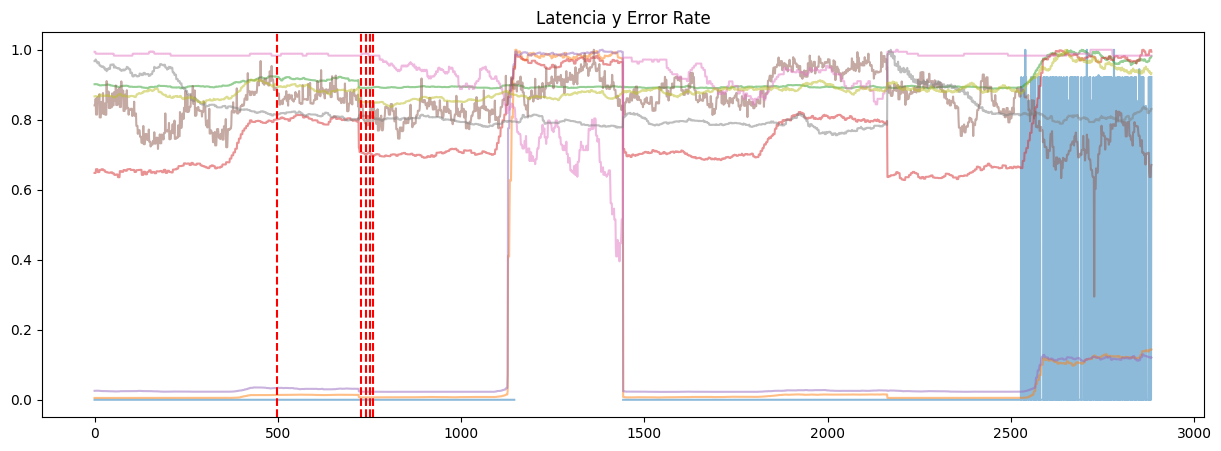

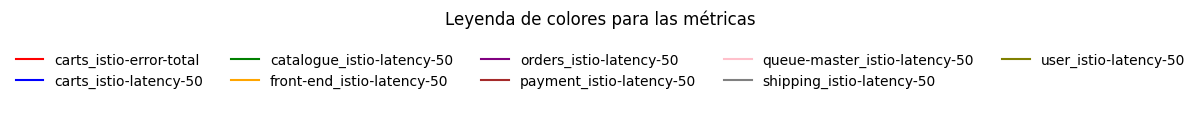

Principales métricas relacionadas con el fallo:
['carts_container-memory-max-usage-bytes', 'rabbitmq_container-memory-rss', 'orders-db_container-memory-rss', 'catalogue-db_container-memory-working-set-bytes', 'catalogue-db_container-memory-usage-bytes', '192-168-76-116-9100_node-disk-read-bytes-total', 'carts_istio-latency-50', 'session-db_container-fs-writes-bytes-total', 'session-db_container-fs-reads-bytes-total', 'user_istio-latency-99']


In [10]:
# ========================================
"""
This script performs the following tasks:
1. Select relevant metrics (latency and errors):
    - Assigns a time index to the dataframe.
    - Filters columns containing "latency-50" or "error".
    - Removes constant columns.
    - Inserts a time column at the beginning of the dataframe.
2. Anomaly detection with Multivariate BOCPD:
    - Applies BOCPD to detect anomalies in the selected metrics.
    - Prints the first 5 timestamps of detected anomalies.
3. Visualize anomaly detection:
    - Normalizes the data for easier visualization.
    - Plots the selected metrics.
    - Marks the first detected anomaly with a red dashed line.
    - Displays the plot.
4. Root cause analysis with BARO:
    - Applies root cause analysis to identify metrics most related to the failure.
    - Prints the top 10 metrics identified as the root cause.
"""
# SECCIÓN DE EVALUACIÓN CON BARO
# ========================================

# 1. Seleccionar métricas relevantes (latencia y errores)
time_col = pd.Series(range(df.shape[0]))  # Asignar un índice de tiempo
selected_cols = [c for c in df.columns if "latency-50" in c or "error" in c]  # Filtrar métricas
selected_df = drop_constant(df[selected_cols])  # Eliminar columnas constantes
selected_df.insert(0, "time", time_col)  # Insertar columna de tiempo

# 2. Detección de anomalías con Multivariate BOCPD
anomalies = bocpd(selected_df)  # Aplicar BOCPD para detectar anomalías
print("Anomalías detectadas en los siguientes timestamps:", anomalies[:5])  # Imprimir los primeros 5 timestamps de anomalías detectadas

# 3. Visualizar la detección de anomalías
import matplotlib.pyplot as plt

# Normalizar datos para facilitar la visualización
for c in selected_df.columns:
    if c != "time":
        selected_df[c] /= selected_df[c].max()  # Normalizar cada columna excepto la columna de tiempo

# Graficar métricas
selected_df.drop("time", axis=1).plot(figsize=(15, 5), title="Latencia y Error Rate", alpha=0.5, legend=None)
# Marcar las primeras 5 anomalías detectadas con líneas rojas
for anomaly_time in anomalies[:5]:
    plt.axvline(x=anomaly_time, color='r', linestyle='--')
plt.show()  # Mostrar el gráfico

# Añadir una leyenda para explicar el significado de cada color
plt.figure(figsize=(10, 1))
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
labels = selected_df.columns[1:]  # Excluir la columna de tiempo
for color, label in zip(colors, labels):
    plt.plot([], [], color=color, label=label)  # Crear líneas vacías para la leyenda
plt.legend(loc='center', ncol=5, frameon=False)
plt.axis('off')  # Ocultar los ejes
plt.title('Leyenda de colores para las métricas')
plt.show()

# 4. Análisis de causa raíz con BARO
ranks = robust_scorer(df, anomalies=anomalies)["ranks"]  # Aplicar el análisis de causa raíz y obtener las métricas más relacionadas con el fallo
print("Principales métricas relacionadas con el fallo:")  # Imprimir las métricas principales
print(ranks[:10])  # Mostrar las 10 principales métricas identificadas como causa raíz

This section evaluates anomalies and performs Root Cause Analysis (RCA) using BARO on the dataset. It consists of four main steps:

1️⃣ Selecting Relevant Metrics:

Extracts only latency and error rate metrics since they are key indicators of failures.
Removes constant columns to keep only useful data.
Adds a time index to structure the data for analysis.

2️⃣ Anomaly Detection with BOCPD:

Applies Multivariate Bayesian Online Change Point Detection (BOCPD) to detect anomalies.
Prints the first detected anomaly timestamps.

3️⃣ Visualizing Anomalies:

Normalizes the selected metrics for easier visualization.
Plots the time series data of the latency and error metrics.
Marks the first detected anomaly with a red vertical line in the plot.

4️⃣ Root Cause Analysis (RCA) with BARO:

Uses robust_scorer to analyze which metrics are the most related to the failure.
Prints the top 10 root cause metrics, helping identify the service or component responsible for the failure.
Key Insights:

✅ This code automates anomaly detection and RCA using state-of-the-art Bayesian techniques.

✅ The graph helps visualize when the failure occurs and how metrics behave.

✅ The ranked list of root causes is crucial for diagnosing failures in microservices.
